In [16]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [3]:
data_dir = pathlib.Path("test_images/")
data_dir

WindowsPath('test_images')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

680

340


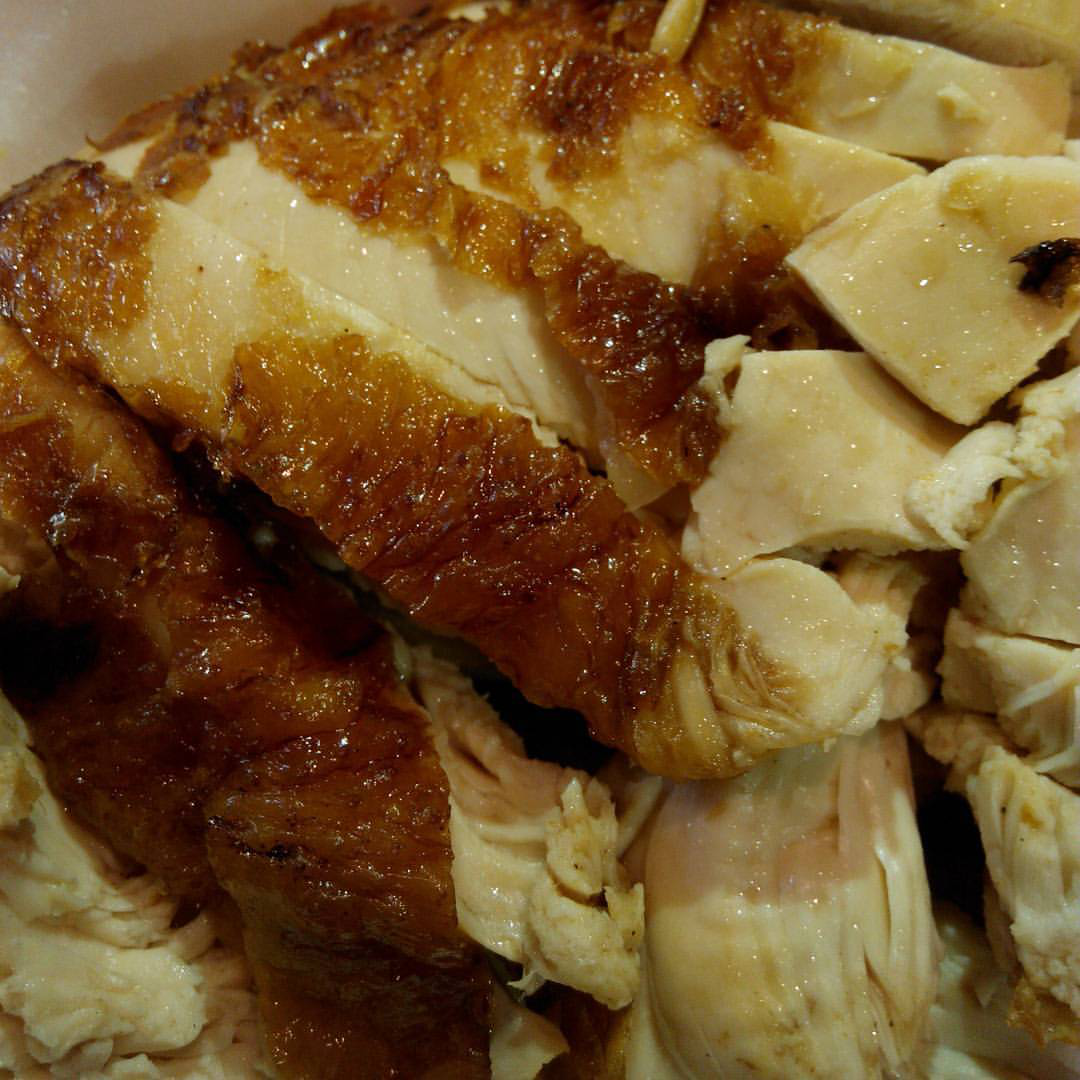

In [5]:
roasted_imgs = list(data_dir.glob('Roasted Chicken Rice/*.jpg'))
print(len(roasted_imgs))
PIL.Image.open(roasted_imgs[5])

340


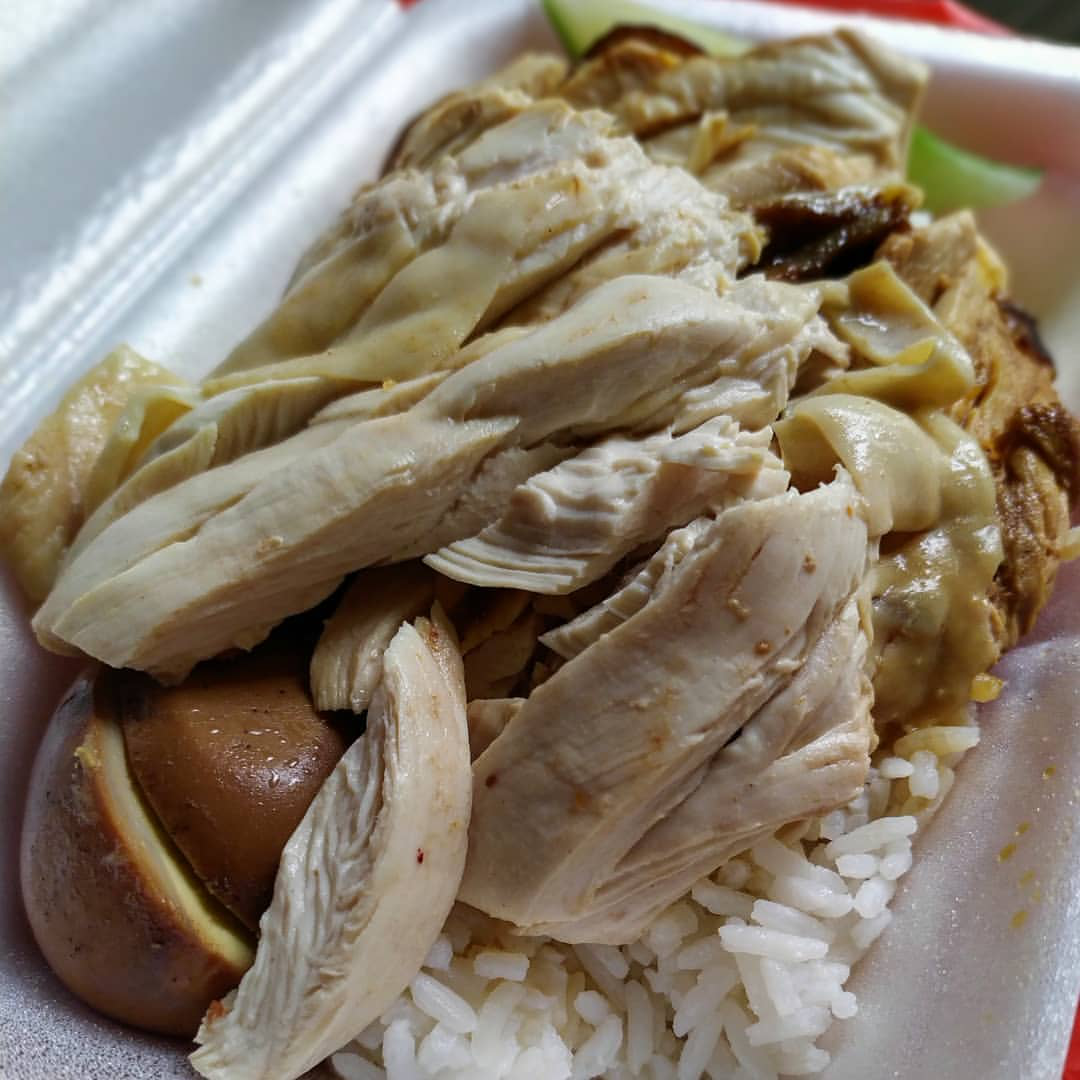

In [6]:
steamed_imgs = list(data_dir.glob('Steamed Chicken Rice/*.jpg'))
print(len(steamed_imgs))
PIL.Image.open(steamed_imgs[1])

In [7]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 680 files belonging to 2 classes.
Using 544 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 680 files belonging to 2 classes.
Using 136 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Roasted Chicken Rice', 'Steamed Chicken Rice']


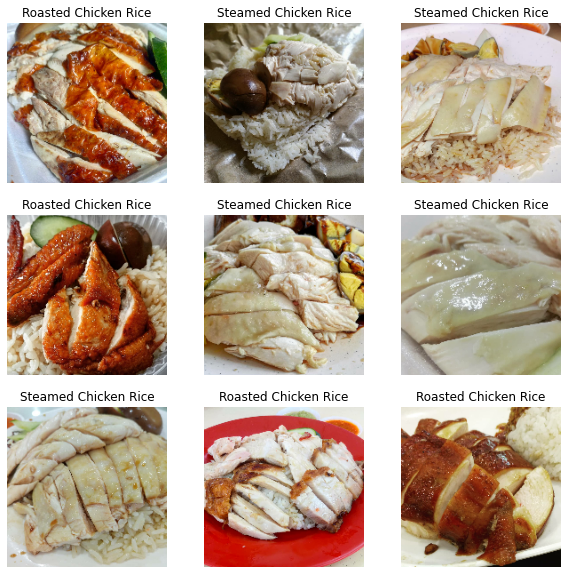

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [21]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# THIS IS Jun Ming Code
#model = Sequential([
#  data_augmentation,
#  layers.Rescaling(1./255),
#  layers.Conv2D(16, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(32, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Conv2D(64, 3, padding='same', activation='relu'),
#  layers.MaxPooling2D(),
#  layers.Dropout(0.2),
#  layers.Flatten(),
#  layers.Dense(128, activation='relu'),
#  layers.Dense(num_classes, name="outputs")
#])

model = Sequential()
# input: 28x28 images with 1 channels -> (28, 28, 1) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3),padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(128, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())



#model = keras.applications.inception_v3.InceptionV3(weights= None, include_top=False, input_shape= (28,28,1))
model.add(Dense(256, activation='relu', name='my_dense'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 180, 180, 32)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_9 (Batc  (None, 180, 180, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 180, 180, 32)     

In [24]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


C:\Users\ianch\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


17/17 [==============================] - 152s 9s/step - loss: 0.5421 - accuracy: 0.7188 - val_loss: 0.6957 - val_accuracy: 0.4853
Epoch 2/30
17/17 [==============================] - 173s 10s/step - loss: 0.2766 - accuracy: 0.9081 - val_loss: 0.6944 - val_accuracy: 0.4853
Epoch 3/30
17/17 [==============================] - 161s 9s/step - loss: 0.2344 - accuracy: 0.9246 - val_loss: 0.6954 - val_accuracy: 0.5147
Epoch 4/30
17/17 [==============================] - 161s 10s/step - loss: 0.1769 - accuracy: 0.9393 - val_loss: 0.6949 - val_accuracy: 0.4853
Epoch 5/30
 3/17 [====>.........................] - ETA: 2:15 - loss: 0.1071 - accuracy: 0.9688

KeyboardInterrupt: 

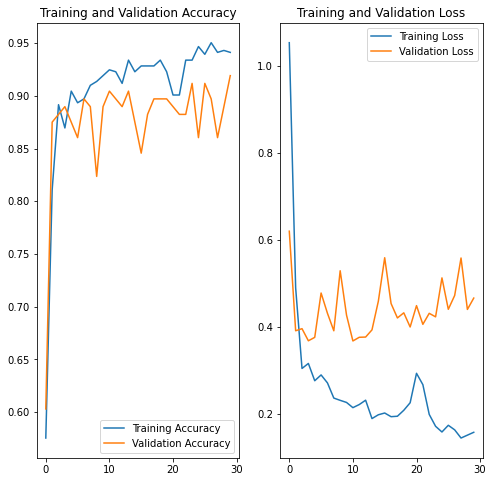

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
test_dir = pathlib.Path("test/")
test_imgs = list(test_dir.glob('*.jpg'))
len(test_imgs)

40

In [36]:
img = tf.keras.utils.load_img(
        test_imgs[2], target_size=(img_height, img_width)
    )
img_array = tf.keras.utils.img_to_array(img)
img_array.shape

(180, 180, 3)

1/1 [==============================] - 0s 13ms/step


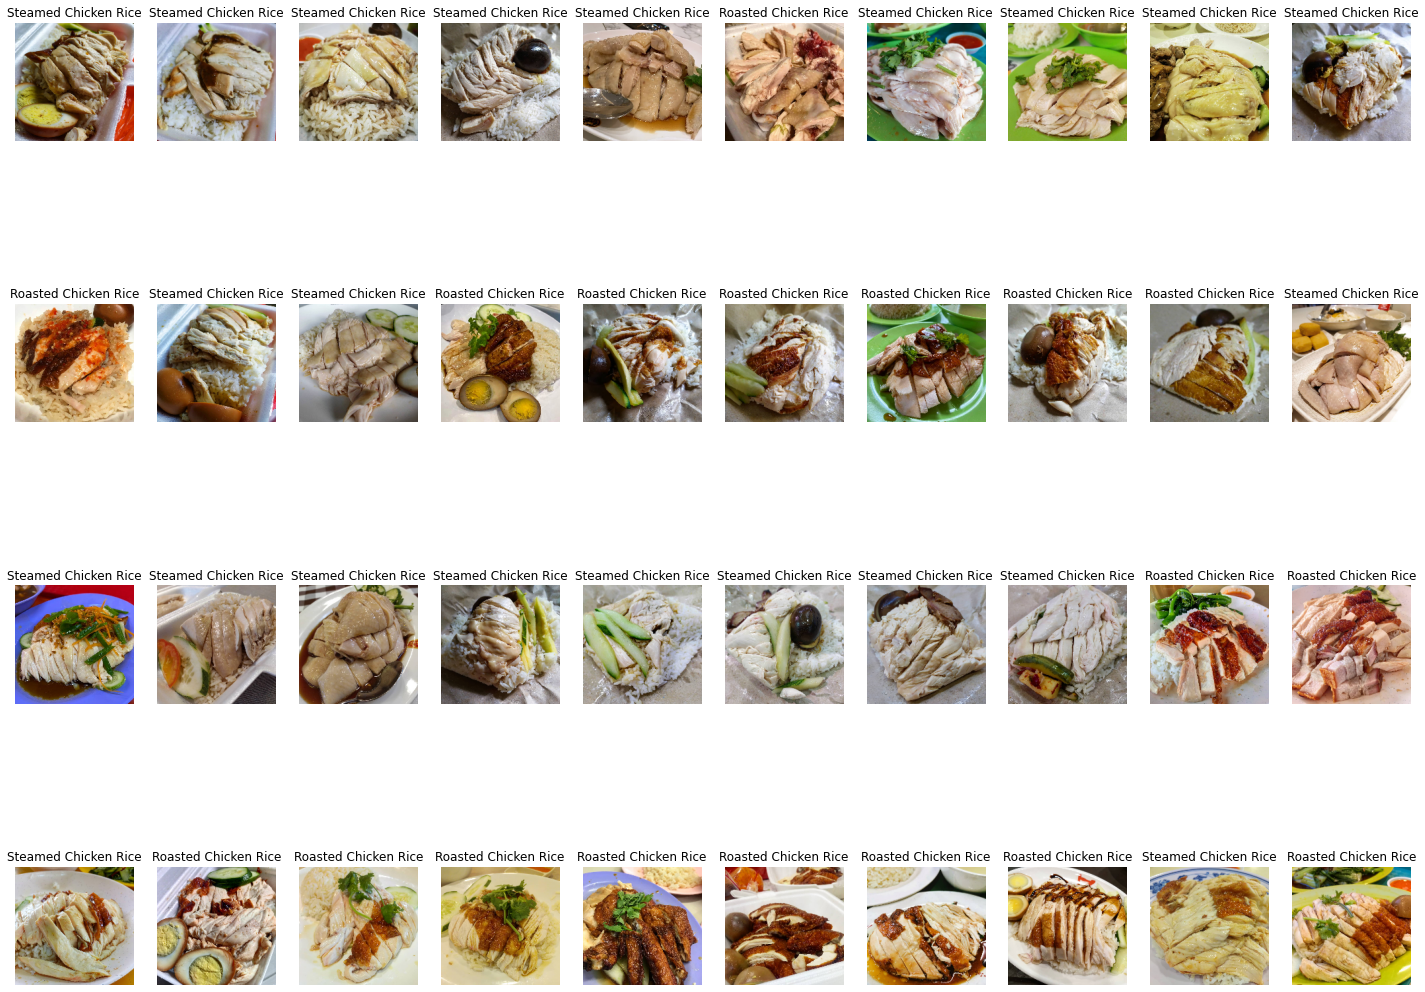

In [48]:
plt.figure(figsize=(30, 30))
for i in range(len(test_imgs)):
    ax = plt.subplot(len(test_imgs) // 10 + 1, 10, i + 1)
    img = tf.keras.utils.load_img(
        test_imgs[i], target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    plt.imshow(img)
    predict = model.predict(img_array)
    score = tf.nn.softmax(predict[0])
    plt.title(format(class_names[np.argmax(score)]))
    plt.axis("off")